In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
#Load & Preprocess Unlabeled Dataset
df_unlabeled = pd.read_csv("preprocessed_Spotify_dataset.csv")

features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
            'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms']

df_unlabeled[features] = df_unlabeled[features].fillna(df_unlabeled[features].mean())

scaler = StandardScaler()
X_unlabeled_scaled = scaler.fit_transform(df_unlabeled[features])

import pickle
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
#finding optimal cluster number
bic_scores = []
aic_scores = []
cluster_range = range(2, 15)

for n in cluster_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_unlabeled_scaled)
    bic_scores.append(gmm.bic(X_unlabeled_scaled))
    aic_scores.append(gmm.aic(X_unlabeled_scaled))

n_clusters = cluster_range[np.argmin(bic_scores)]
print(f"Optimal number of clusters based on BIC: {n_clusters}")

Optimal number of clusters based on BIC: 14


In [ ]:
#Applying GMM
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
df_unlabeled['Cluster'] = gmm.fit_predict(X_unlabeled_scaled)

proba_df = pd.DataFrame(gmm.predict_proba(X_unlabeled_scaled), columns=[f'Cluster_{i}' for i in range(n_clusters)])

df_unlabeled = df_unlabeled.join(proba_df)

with open("gmm_model.pkl", "wb") as f:
    pickle.dump(gmm, f)

df_unlabeled.to_csv("gmm_clustered_songs.csv", index=False)

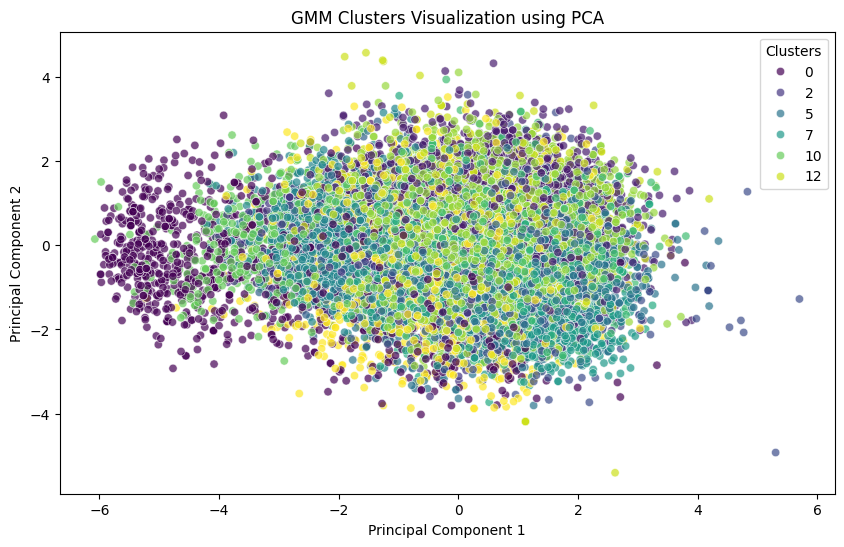

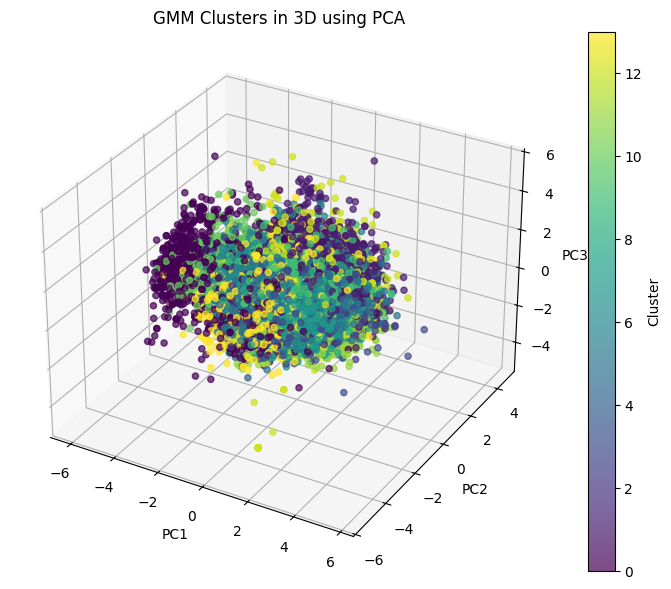

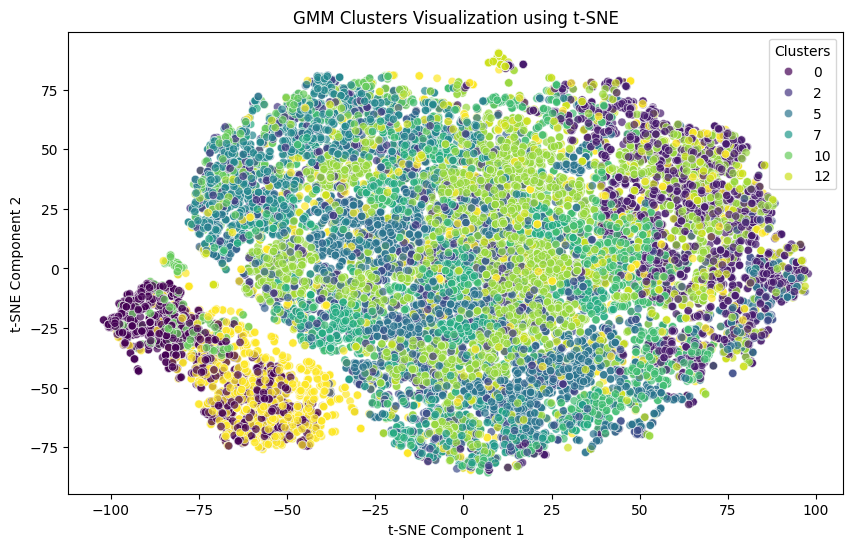

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle

# Load the clustered dataset
df = pd.read_csv("gmm_clustered_songs.csv")
features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
            'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms']

# Load the scaler and transform features
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
X_scaled = scaler.transform(df[features])

# Load GMM model
with open("gmm_model.pkl", "rb") as f:
    gmm = pickle.load(f)

clusters = df['Cluster']
n_clusters = len(np.unique(clusters))

# PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', alpha=0.7)
plt.title("GMM Clusters Visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Clusters")
plt.show()

# PCA for 3D Visualization
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=clusters, cmap='viridis', alpha=0.7)
ax.set_title("GMM Clusters in 3D using PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(sc, label="Cluster")
plt.show()

# t-SNE for Non-linear Dimensionality Reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters, palette='viridis', alpha=0.7)
plt.title("GMM Clusters Visualization using t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Clusters")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


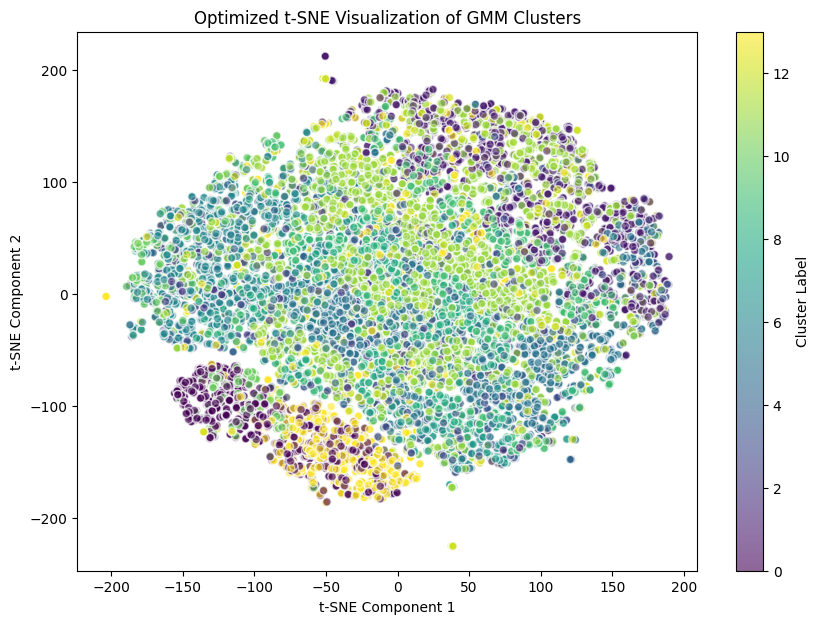

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load the clustered dataset
df = pd.read_csv("gmm_clustered_songs.csv")

# Select only the numerical features for dimensionality reduction
features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
            'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms']

X = df[features]

# Reduce dimensions with PCA before t-SNE
pca = PCA(n_components=7, random_state=42)  # Reduce dimensions to 30 before t-SNE
X_pca = pca.fit_transform(X)

# Apply optimized t-SNE
tsne = TSNE(n_components=2, perplexity=10, n_iter=3000, learning_rate=200, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Add t-SNE results to the dataframe
df["tSNE-1"] = X_tsne[:, 0]
df["tSNE-2"] = X_tsne[:, 1]

# Plot optimized t-SNE
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df["tSNE-1"], df["tSNE-2"], c=df["Cluster"], cmap="viridis", alpha=0.6, edgecolors="w")
plt.colorbar(scatter, label="Cluster Label")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Optimized t-SNE Visualization of GMM Clusters")
plt.show()


In [14]:
import pandas as pd

df = pd.read_csv("gmm_clustered_songs.csv")

features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
            'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms']

cluster_summary = df.groupby('Cluster')[features].mean()
print(cluster_summary)

         Danceability    Energy       Key  Loudness  Speechiness  \
Cluster                                                            
0           -0.818036 -0.717622  0.048396 -1.220520    -0.428024   
1            0.528699 -0.001718  0.087939  0.050209     1.809098   
2           -0.261988 -0.444286  0.078459 -0.426755    -0.907664   
3            0.081451  0.715835  0.086108  0.463608     0.165675   
4            0.019902  0.018784 -0.034136 -0.194779    -0.707228   
5            0.051668  0.420475  0.359293  0.425042    -0.171416   
6           -0.657933 -1.102263 -0.086052 -0.552149    -0.877075   
7           -0.833687  1.398370 -0.029974  0.858652     0.046354   
8           -0.037535  0.118949 -1.081438  0.272684    -0.782452   
9            0.345628  0.198883 -1.365000  0.351131     0.422263   
10          -0.874775 -1.549546 -0.140811 -1.410193    -0.836256   
11           0.200410  0.108561  0.654126  0.259972    -0.102088   
12           0.457457  0.113491  0.066928  0.031

In [15]:
#classification of clusters based on audio features
import pandas as pd
import pickle

df_unlabeled = pd.read_csv("gmm_clustered_songs.csv")

def cluster_mapping(row):
    if row["Loudness"] > 0.3 and row["Energy"] > 0.6:
        if row["Instrumentalness"] < -0.3:
            return "Hard Rock / Heavy Metal / Punk Rock"
        elif row["Speechiness"] > 0.4:
            return "Rap / Hip-Hop"
        else:
            return "Rock / Alternative Rock / Classic Rock"
    elif row["Acousticness"] > 0.6 and row["Loudness"] < -0.5:
        return "Classical / Orchestral / Ambient"
    elif row["Danceability"] > 0.5 and row["Valence"] > 0:
        if row["Energy"] > 0.6:
            return "Pop / Dance / Commercial Pop"
        else:
            return "Indie Pop / Synth Pop"
    elif row["Speechiness"] > 0.4 and row["Energy"] > 0.5:
        return "Hip-Hop / Rap / R&B"
    elif row["Acousticness"] > 0.4 and row["Energy"] < 0.5:
        return "Folk / Singer-Songwriter / Acoustic Pop"
    elif row["Tempo"] > 0.4 and row["Loudness"] > -0.3:
        if row["Danceability"] > 0.5:
            return "EDM / House / Techno"
        else:
            return "Electronic / Experimental"
    elif row["Instrumentalness"] > 1.0 and row["Acousticness"] > 0.5:
        return "Jazz / Blues / Instrumental"
    elif row["Liveness"] > 0.3 and row["Energy"] > 0.4:
        return "Live / Alternative / Jam Band"
    else:
        return "Alternative / Indie / Soft Rock"

cluster_summary["Genre"] = cluster_summary.apply(cluster_mapping, axis=1)

df_unlabeled = df_unlabeled.merge(cluster_summary["Genre"], on="Cluster", how="left")

df_unlabeled.to_csv("gmm_cluster_genre_labeled_songs.csv", index=False)

print("Cluster-based genre classification done.")

Cluster-based genre classification done.
